In [1]:
import os
import pandas as pd
import numpy as np
import warnings

from fbprophet import Prophet
# Global settings
warnings.filterwarnings("ignore") # To ignore warnings
n_jobs = -1 # This parameter conrols the parallel processing. -1 means using all processors.
random_state = 42 # This parameter controls the randomness of the data. Using some int value to get same results everytime this code is run.

# Load Data

In [2]:
df = pd.read_csv('HouseVar.csv')
print(f'Shape of data= {df.shape}')

Shape of data= (133919, 48)


In [4]:
from dfply import *

In [5]:
df.columns

Index(['Unnamed: 0', 'Area', 'Address', 'St', '交易年月日', 'year', '交易標的', '交易筆棟數',
       '建物型態', '建物現況格局.廳', '建物現況格局.房', '建物現況格局.衛', '建物現況格局.隔間', '有無管理組織',
       '總價元', '總坪數', '單價元坪', '車位數', 'floor', 'EightCount', 'ParkCount',
       'FuneralCount', 'GasCount', 'CrimeCount', 'PoliceCount', 'busCount',
       'subwayCount', 'govCount', 'clinicCount', 'hospitalCount',
       'pharmacyCount', 'fireareaCount', 'firewayCount', 'martCount',
       'mallCount', 'cinemaCount', '土地面積', '總人口數', '男性人數', '女性人數', '人口密度',
       '每戶人數', '每戶成年人數', '所得收入總計', '可支配所得', '消費支出', '儲蓄', '所得總額'],
      dtype='object')

In [6]:
df = df.rename({'建物現況格局.房':'room', '建物現況格局.衛':'bath','單價元坪':'y'}, axis=1)
df.head()

Unnamed: 0 Area               Address    St    交易年月日  year          交易標的  \
0           1  中山區    臺北市中山區建國北路二段61~90號  建國北路  1030430  2014  房地(土地+建物)+車位   
1           2  中山區    臺北市中山區林森北路301~330號  林森北路  1030702  2014     房地(土地+建物)   
2           3  中山區  臺北市中山區新生北路三段56巷1~30號  新生北路  1030127  2014     房地(土地+建物)   
3           4  中山區   臺北市中山區明水路672巷31~60號   明水路  1030218  2014  房地(土地+建物)+車位   
4           5  中山區        臺北市中山區農安街1~30號   農安街  1090307  2020  房地(土地+建物)+車位   

       交易筆棟數    建物型態  建物現況格局.廳  ...    男性人數    女性人數   人口密度  每戶人數  每戶成年人數  \
0  土地2建物1車位1  辦公商業大樓         0  ...  104138  120569  16423  2.89    2.51   
1  土地1建物1車位0      套房         1  ...  104138  120569  16423  2.89    2.51   
2  土地1建物1車位0      套房         1  ...  104138  120569  16423  2.89    2.51   
3  土地1建物1車位1      華廈         1  ...  104138  120569  16423  2.89    2.51   
4  土地1建物1車位1    住宅大樓         1  ...  104138  120569  16423  2.89    2.51   

    所得收入總計    可支配所得     消費支出      儲蓄     所得總額  
0  1614178  1339702  1071429  268273  1720988  
1  1614178  1339702  1071429  268273  1720988  
2  1614178  1339702  1071429  268273  1720988  
3  1614178  1339702  1071429  268273  1720988  
4  1614178  1339702  1071429  268273  1720988  

[5 rows x 48 columns]

In [8]:
mDf = df >> filter_by(X.room < 11, X.bath < 10, X.車位數 < 5,
                      X.總坪數 < 75, X.總坪數 > 10, X.總價元 > 7000000,
                      X.總價元 < 30000000, X.y < 1000000, 
                      X.y > 150000, X.year > 2013) >> select(X.交易年月日, X.year, X.Area, X.y)

In [9]:
mDf['Month'] = mDf['交易年月日'].astype(str).str[3:5]
mDf.sort_values(by=['year', 'Month'], inplace=True, ascending=True)

In [10]:
mDf = mDf >> filter_by(X.Month != "00")
mDf.head()

交易年月日  year Area              y Month
178  1030114  2014  中山區  420867.714908    01
286  1030126  2014  中山區  688948.609971    01
484  1030104  2014  中山區  644411.509809    01
508  1030102  2014  中山區  751315.909091    01
679  1030123  2014  中山區  530021.354335    01

In [11]:
mDf['ds'] = mDf['year'].astype(str) + '-' + mDf['Month'].astype(str)

In [12]:
mDf

交易年月日  year Area              y Month       ds
178     1030114  2014  中山區  420867.714908    01  2014-01
286     1030126  2014  中山區  688948.609971    01  2014-01
484     1030104  2014  中山區  644411.509809    01  2014-01
508     1030102  2014  中山區  751315.909091    01  2014-01
679     1030123  2014  中山區  530021.354335    01  2014-01
...         ...   ...  ...            ...   ...      ...
131395  1090605  2020  萬華區  570306.401779    06  2020-06
131751  1090601  2020  萬華區  482094.375000    06  2020-06
132299  1090601  2020  萬華區  444975.963387    06  2020-06
69847   1090701  2020  南港區  616242.007366    07  2020-07
70901   1090707  2020  南港區  558762.725435    07  2020-07

[71101 rows x 6 columns]

In [13]:
mDf2 = mDf >> select(X.ds, X.Area, X.y)
mDf2 = mDf2.rename({'單價元坪':'y'}, axis=1)

In [15]:
mDf2['ds'] =  pd.to_datetime(mDf2['ds'])

In [16]:
mDf2.head()

ds Area              y
178 2014-01-01  中山區  420867.714908
286 2014-01-01  中山區  688948.609971
484 2014-01-01  中山區  644411.509809
508 2014-01-01  中山區  751315.909091
679 2014-01-01  中山區  530021.354335

# Check Area data

In [65]:
mDf.groupby(['Area'], as_index=True).mean()[['y']]

y
Area               
中山區   619180.395583
中正區   655865.093676
信義區   614374.451405
內湖區   509188.917861
北投區   443499.015554
南港區   519658.258729
士林區   516956.032548
大同區   543320.098050
大安區   695618.537132
文山區   454652.602543
松山區   652970.463698
萬華區   493467.250409

In [74]:
Shilin = mDf2 >> filter_by(X.Area == '士林區') >> select(X.ds, X.y)
ShilinDf = Shilin.groupby(['ds',], as_index=True).mean()[['y']].reset_index()
ShilinDf.tail()

ds              y
73 2020-02-01  449315.505116
74 2020-03-01  465186.324092
75 2020-04-01  438471.916905
76 2020-05-01  466903.111447
77 2020-06-01  549601.784404

# Split df by Area

In [75]:
Area = ['Songshan', 'Xinyi', 'Daan', 
        'Zhongshan', 'Zhongzheng', 'Datong',
        'Wanhua', 'Wenshan', 'Nangang', 
        'Neihu', 'Shilin', 'Beitou']
AreaC = ['松山區', '信義區','大安區',
         '中山區','中正區','大同區',
         '萬華區','文山區','南港區', 
         '內湖區', '士林區','北投區']

In [78]:
dictArea = {'Songshan':"", 'Xinyi':"", 'Daan':"", 
        'Zhongshan':"", 'Zhongzheng':"", 'Datong':"",
        'Wanhua':"", 'Wenshan':"", 'Nangang':"", 
        'Neihu':"", 'Shilin':"", 'Beitou':""}

for i, j in zip(Area, AreaC):
    tmp = mDf >> filter_by(X.Area == j) >> select(X.ds, X.y)
    tmp = tmp.groupby(['ds',], as_index=True).mean()[['y']].reset_index()
    dictArea[i] = tmp

# Modeling-Prophet

## Quick Run

In [139]:
dictAreaPred = {'Songshan': "", 'Xinyi': "", 'Daan': "",
                'Zhongshan': "", 'Zhongzheng': "", 'Datong': "",
                'Wanhua': "", 'Wenshan': "", 'Nangang': "",
                'Neihu': "", 'Shilin': "", 'Beitou': ""}
for i in Area:
    
    m = Prophet(changepoint_prior_scale=1.2).fit(dictArea[i])
    future = m.make_future_dataframe(periods=36, freq='MS')
    forecast = m.predict(future)
    tmp = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    
    dictAreaPred[i] = tmp

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

In [140]:
# Output predict Outcomes
for i in Area:
     dictAreaPred[i].to_csv("/Users/yunmo/Documents/iii/FinalReport/House/output/Prophet/pred/"+i+".csv")

## Standard Run

### Songshan

#### Model

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


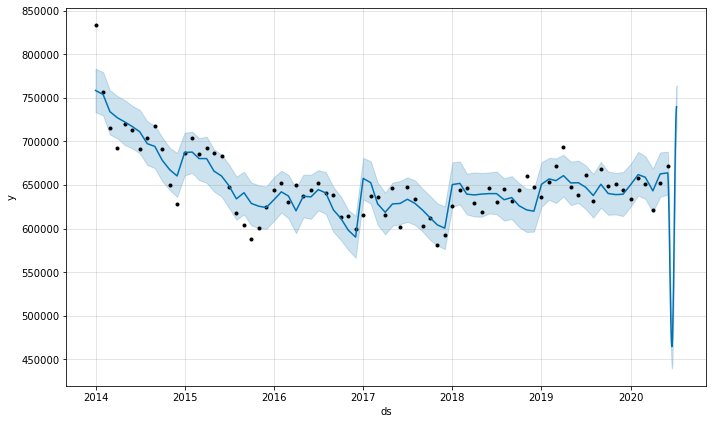

In [145]:
m = Prophet(seasonality_mode='multiplicative').fit(dictArea['Songshan'])
future = m.make_future_dataframe(periods=36)  # 3652
fcst = m.predict(future) 
fig = m.plot(fcst)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


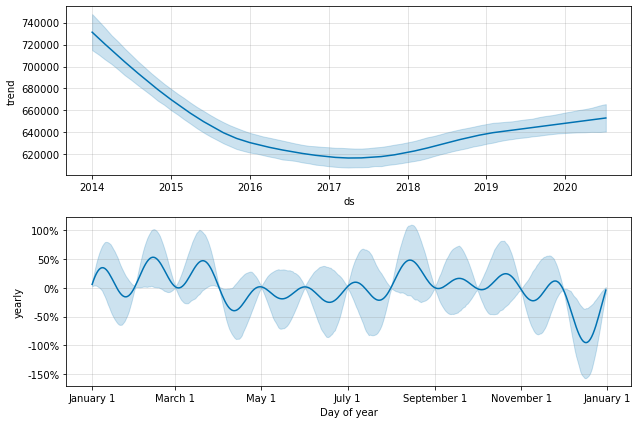

In [146]:
m = Prophet(seasonality_mode='multiplicative', mcmc_samples=300).fit(dictArea['Songshan'])  #300
fcst = m.predict(future)
trendFig = m.plot_components(fcst)

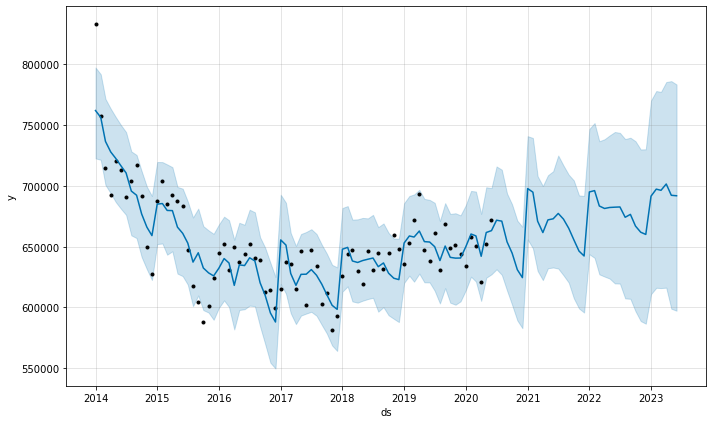

In [147]:
future = m.make_future_dataframe(periods=36, freq='MS')
fcst = m.predict(future)
fig = m.plot(fcst)

In [148]:
fcst[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)

ds           yhat     yhat_lower     yhat_upper
102 2022-07-01  682698.434613  619657.728680  743679.018894
103 2022-08-01  674222.902844  607458.450778  738562.820858
104 2022-09-01  676592.556583  607132.227791  739687.453629
105 2022-10-01  666989.469954  596928.371021  736811.196402
106 2022-11-01  661918.534591  588820.985259  730028.232144
107 2022-12-01  660095.192284  586661.485645  730155.933509
108 2023-01-01  691599.310844  610964.950982  770331.965455
109 2023-02-01  697369.160130  616199.665661  778084.829407
110 2023-03-01  696396.342686  615966.602276  777374.053869
111 2023-04-01  701604.926766  616279.086656  785471.959487
112 2023-05-01  692303.147862  598984.773849  786247.053662
113 2023-06-01  691920.121180  597306.880074  783496.933095

#### Trend Changepoints

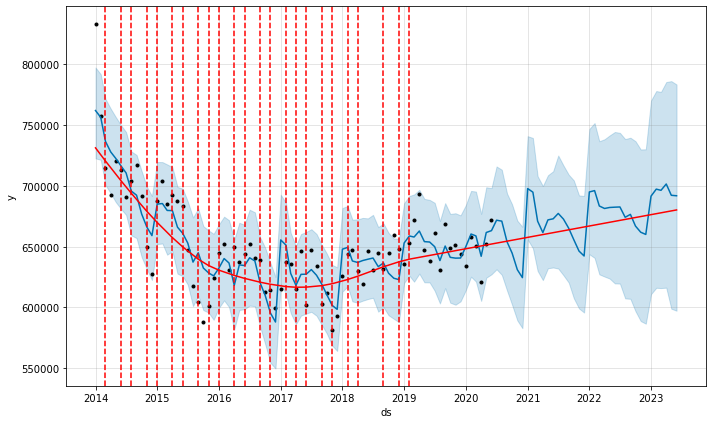

In [149]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(fcst)
chaFig = add_changepoints_to_plot(fig.gca(), m, fcst)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


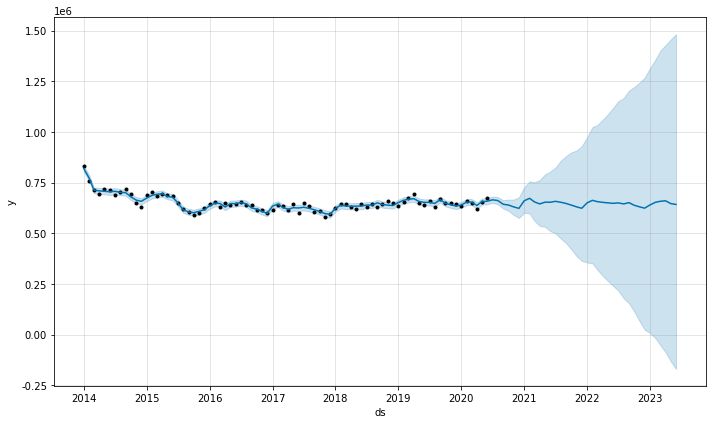

In [128]:
# Adjusting trend flexibility
m = Prophet(changepoint_prior_scale=1.2).fit(dictArea['Songshan'])
future = m.make_future_dataframe(periods=36, freq='MS')
forecast = m.predict(future)
fig = m.plot(forecast)

### Xinyi

#### Model

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


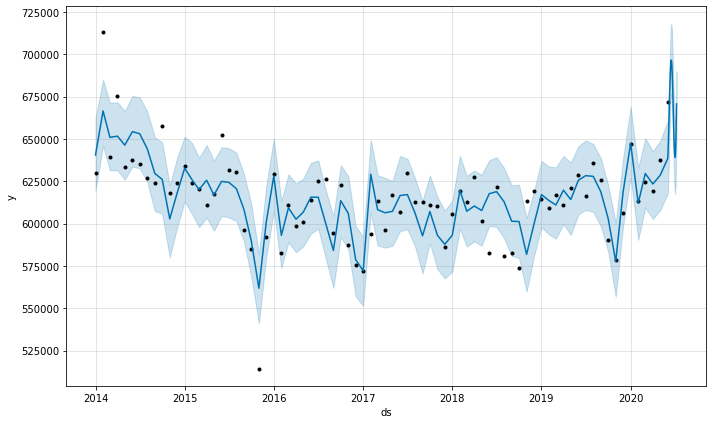

In [154]:
m = Prophet(seasonality_mode='multiplicative').fit(dictArea['Xinyi'])
future = m.make_future_dataframe(periods=36)
fcst = m.predict(future) 
fig = m.plot(fcst)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


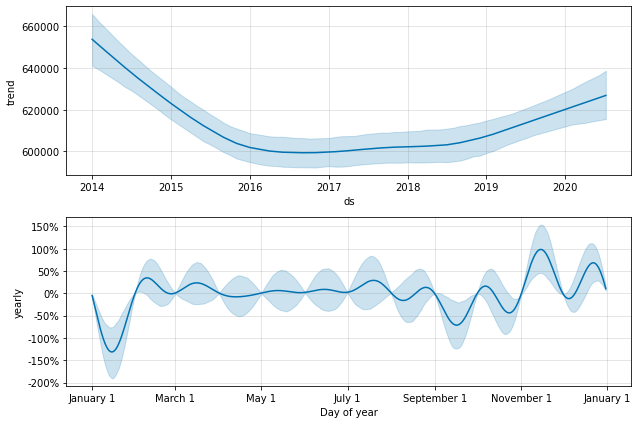

In [155]:
m = Prophet(seasonality_mode='multiplicative', mcmc_samples=300).fit(dictArea['Xinyi'])  #300
fcst = m.predict(future)
trendFig = m.plot_components(fcst)

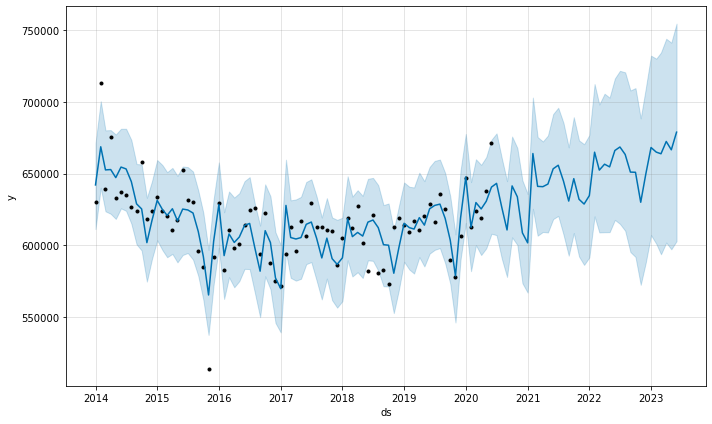

In [156]:
future = m.make_future_dataframe(periods=36, freq='MS')
fcst = m.predict(future)
fig = m.plot(fcst)

#### Trend Changepoints

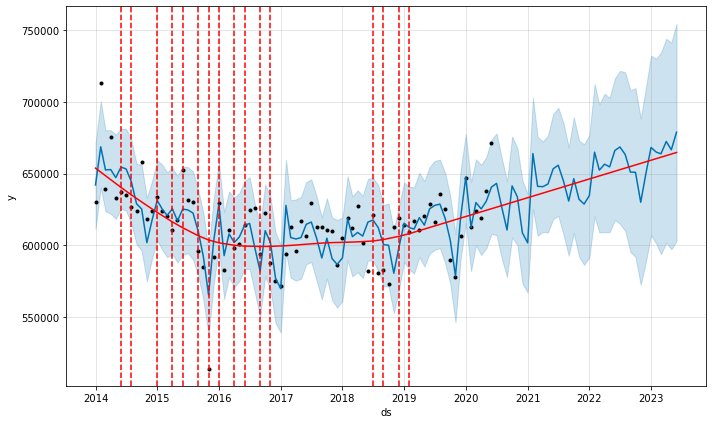

In [158]:
# Python
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(fcst)
chaFig = add_changepoints_to_plot(fig.gca(), m, fcst)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


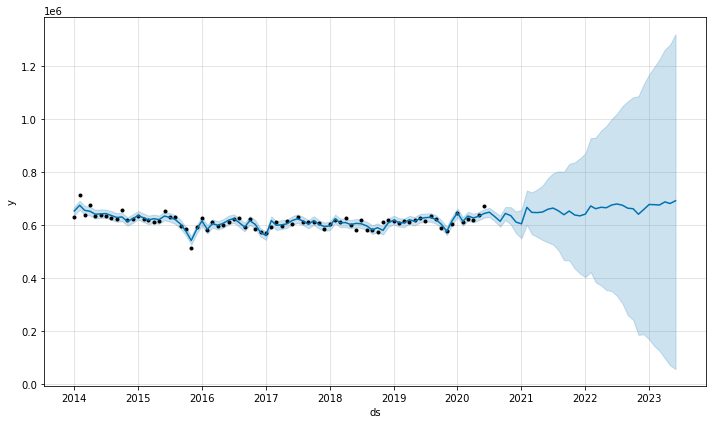

In [127]:
# Adjusting trend flexibility
m = Prophet(changepoint_prior_scale=1.2).fit(dictArea['Xinyi'])
future = m.make_future_dataframe(periods=36, freq='MS')
forecast = m.predict(future)
fig = m.plot(forecast)

### Daan

#### Model

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


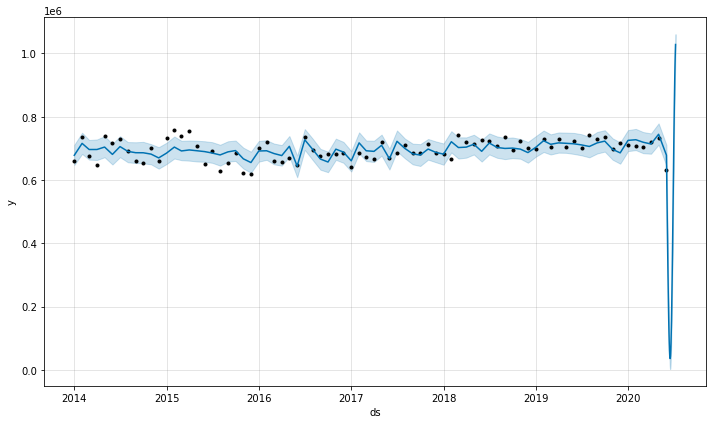

In [162]:
m = Prophet(seasonality_mode='multiplicative').fit(dictArea['Daan'])
future = m.make_future_dataframe(periods=36)  # 3652
fcst = m.predict(future) 
fig = m.plot(fcst)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


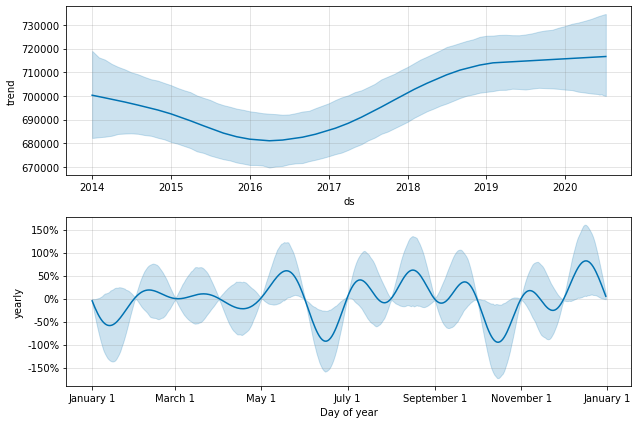

In [163]:
m = Prophet(seasonality_mode='multiplicative', mcmc_samples=300).fit(dictArea['Daan'])
fcst = m.predict(future)
trendFig = m.plot_components(fcst)

In [164]:
trendFig.savefig('/Users/yunmo/Documents/iii/FinalReport/House/output/Prophet/plot/trend/Daan.png')

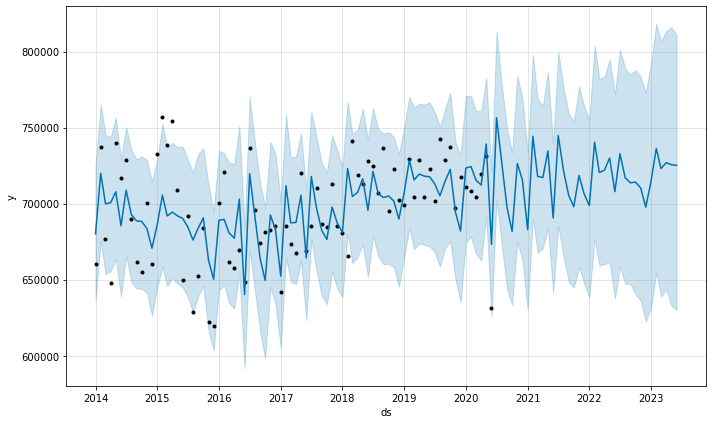

In [165]:
future = m.make_future_dataframe(periods=36, freq='MS')
fcst = m.predict(future)
fig = m.plot(fcst)

#### Trend Changepoints

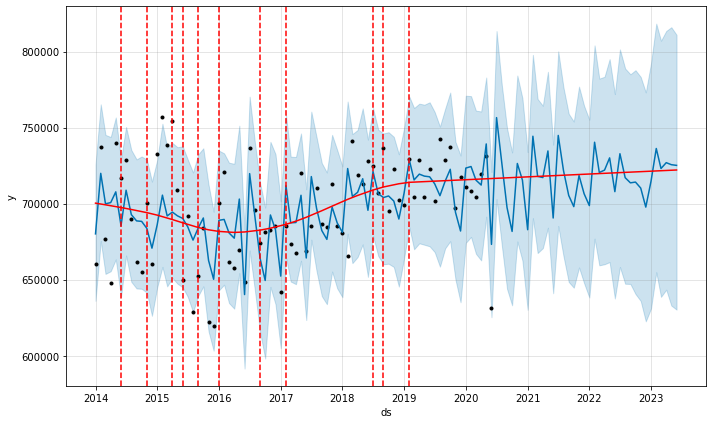

In [170]:
fig = m.plot(fcst)
chaFig = add_changepoints_to_plot(fig.gca(), m, fcst)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


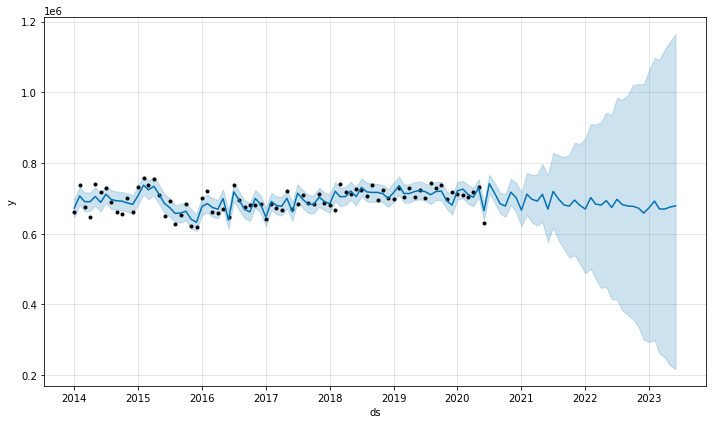

In [168]:
# Adjusting trend flexibility
m = Prophet(changepoint_prior_scale=1.2).fit(dictArea['Daan'])
future = m.make_future_dataframe(periods=36, freq='MS')
forecast = m.predict(future)
fig = m.plot(forecast)

### Wenshan

#### Model

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


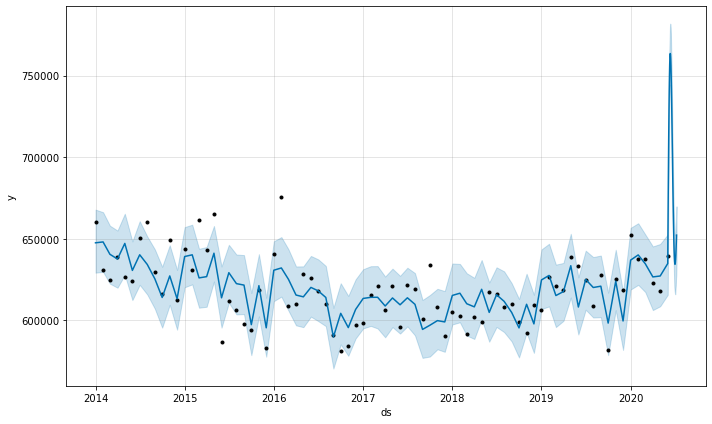

In [172]:
m = Prophet(seasonality_mode='multiplicative').fit(dictArea['Zhongshan'])
future = m.make_future_dataframe(periods=36)  # 3652
fcst = m.predict(future) 
fig = m.plot(fcst)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


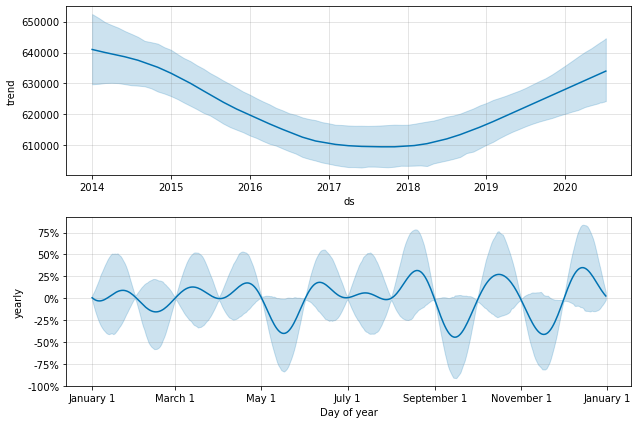

In [173]:
m = Prophet(seasonality_mode='multiplicative', mcmc_samples=300).fit(dictArea['Zhongshan'])
fcst = m.predict(future)
trendFig = m.plot_components(fcst)

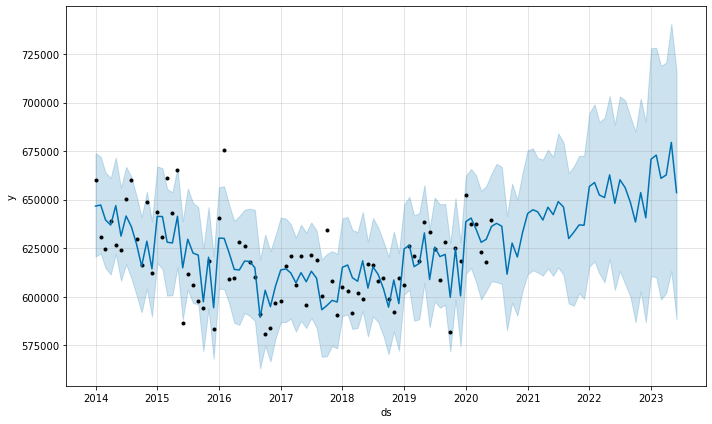

In [175]:
future = m.make_future_dataframe(periods=36, freq='MS')
fcst = m.predict(future)
fig = m.plot(fcst)

#### Trend Changepoints

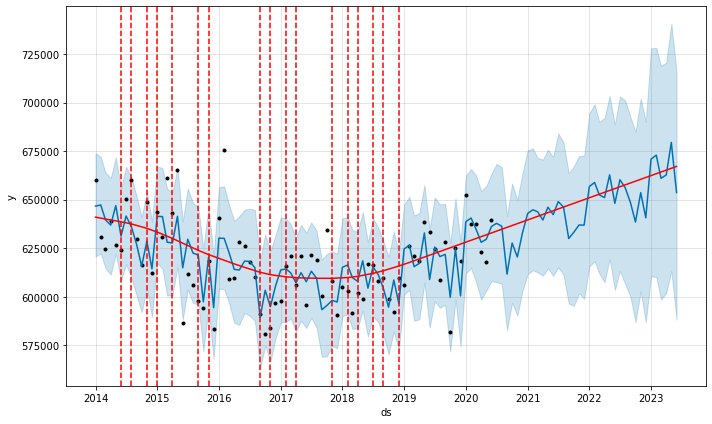

In [176]:
fig = m.plot(fcst)
chaFig = add_changepoints_to_plot(fig.gca(), m, fcst)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


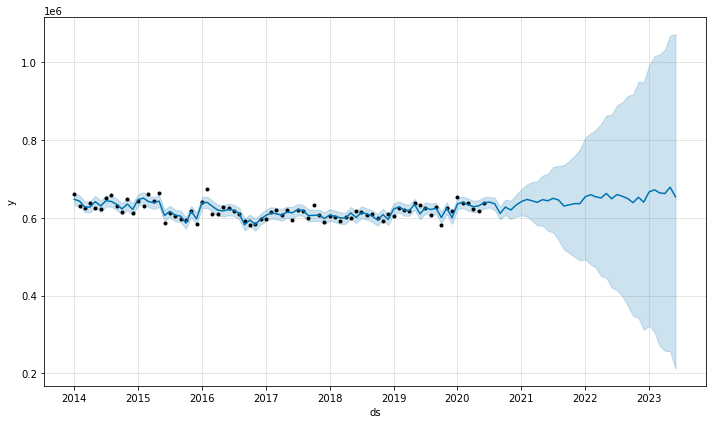

In [138]:
# Adjusting trend flexibility
m = Prophet(changepoint_prior_scale=1.2).fit(dictArea['Zhongshan'])
future = m.make_future_dataframe(periods=36, freq='MS')
forecast = m.predict(future)
fig = m.plot(forecast)

### Zhongzheng

#### Model

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


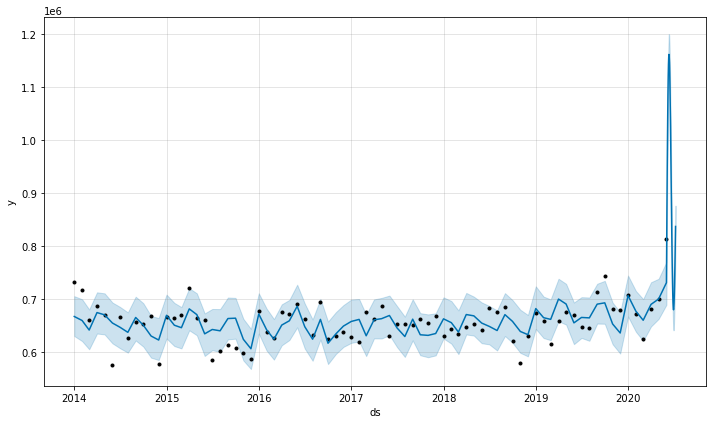

In [178]:
m = Prophet(seasonality_mode='multiplicative').fit(dictArea['Zhongzheng'])
future = m.make_future_dataframe(periods=36)  # 3652
fcst = m.predict(future) 
fig = m.plot(fcst)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


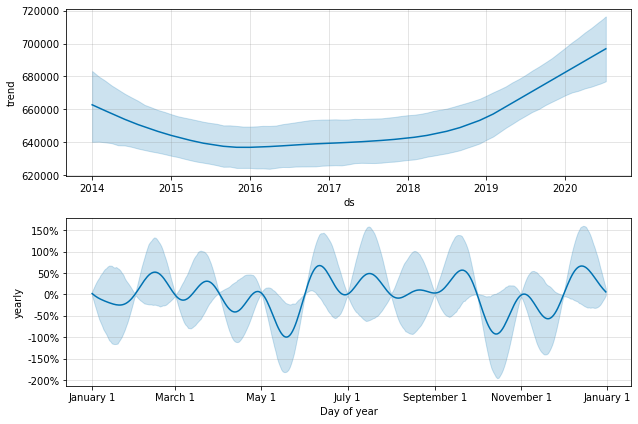

In [180]:
m = Prophet(seasonality_mode='multiplicative', mcmc_samples=300).fit(dictArea['Zhongzheng'])
fcst = m.predict(future)
trendFig = m.plot_components(fcst)

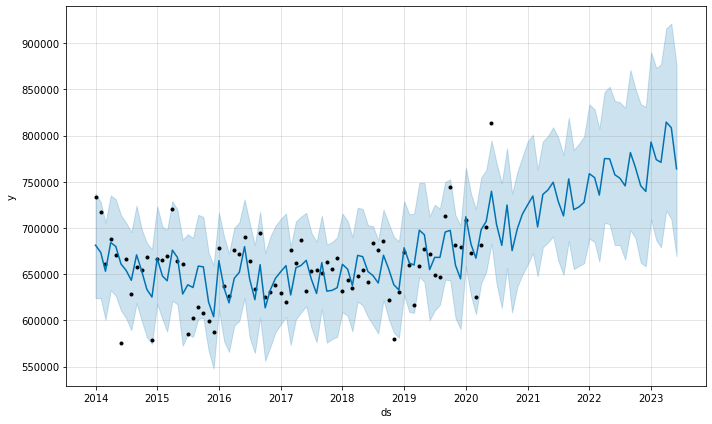

In [182]:
future = m.make_future_dataframe(periods=36, freq='MS')
fcst = m.predict(future)
fig = m.plot(fcst)

In [183]:
fcst[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)

ds           yhat     yhat_lower     yhat_upper
102 2022-07-01  753886.213994  681526.818376  836196.289982
103 2022-08-01  745599.540724  665797.326688  829957.926925
104 2022-09-01  781679.504268  697811.506119  871033.982193
105 2022-10-01  765388.202645  689021.575044  850653.445548
106 2022-11-01  745707.448819  662492.023756  834085.354970
107 2022-12-01  739590.920883  658534.520645  831101.753069
108 2023-01-01  793128.488540  709611.773369  890612.002927
109 2023-02-01  774023.488136  686862.596399  873257.718997
110 2023-03-01  771044.665288  679163.257347  877169.784930
111 2023-04-01  814663.958221  719126.897266  916088.369877
112 2023-05-01  808550.484788  709700.601303  921233.644659
113 2023-06-01  764040.454233  669395.416330  876593.621934

#### Trend Changepoints

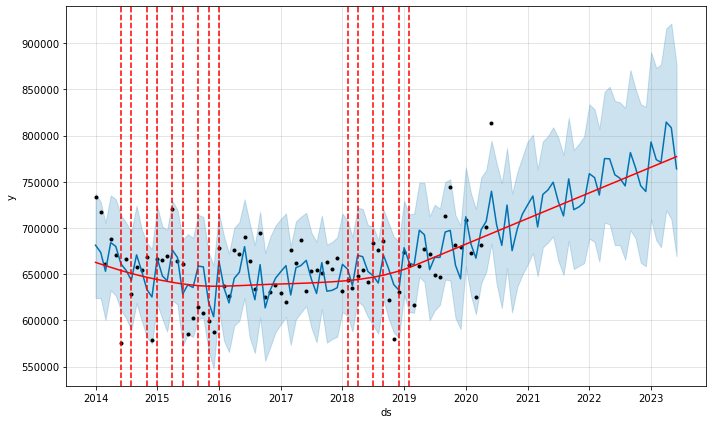

In [184]:
fig = m.plot(fcst)
chaFig = add_changepoints_to_plot(fig.gca(), m, fcst)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


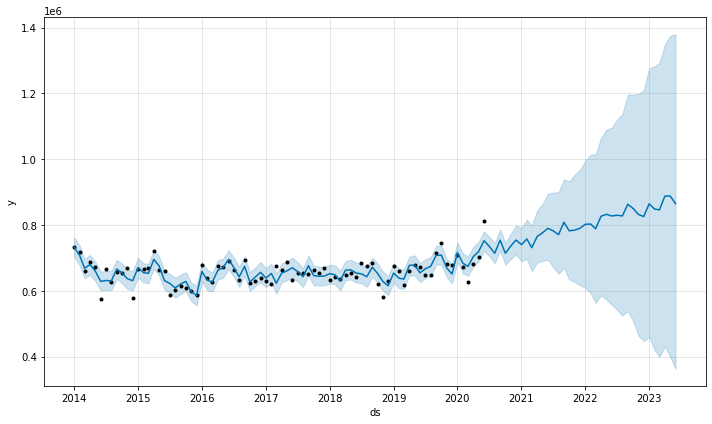

In [186]:
# Adjusting trend flexibility
m = Prophet(changepoint_prior_scale=1.2).fit(dictArea['Zhongzheng'])
future = m.make_future_dataframe(periods=36, freq='MS')
forecast = m.predict(future)
fig = m.plot(forecast)

### Datong

#### Model

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


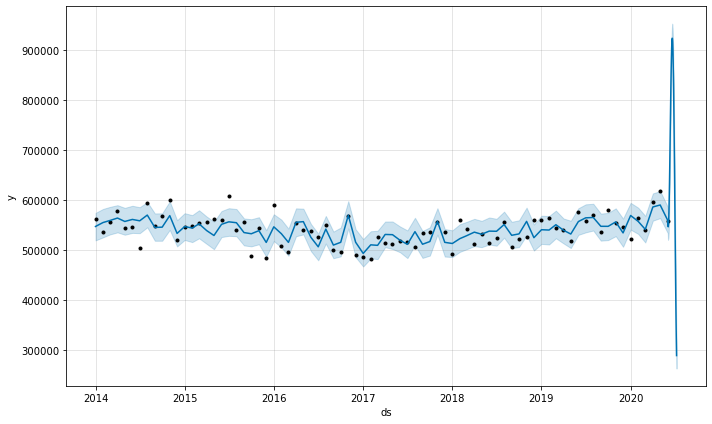

In [311]:
m = Prophet(seasonality_mode='multiplicative').fit(dictArea['Datong'])
future = m.make_future_dataframe(periods=36) 
fcst = m.predict(future) 
fig = m.plot(fcst)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


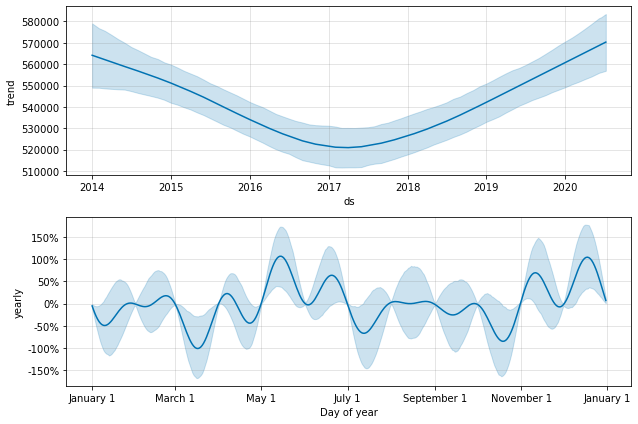

In [312]:
m = Prophet(seasonality_mode='multiplicative', mcmc_samples=300).fit(dictArea['Datong'])
fcst = m.predict(future)
trendFig = m.plot_components(fcst)

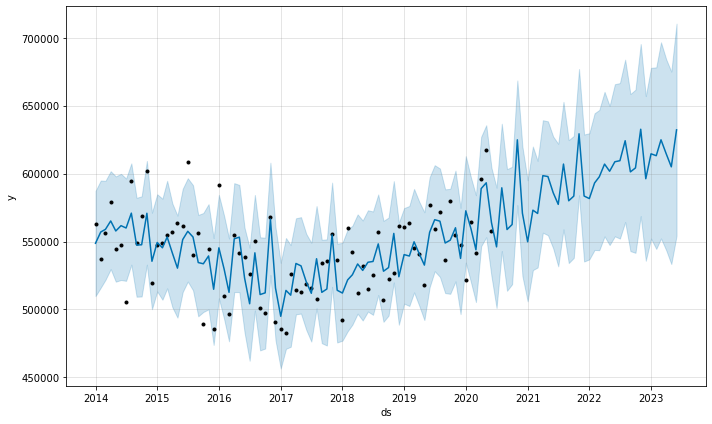

In [314]:
future = m.make_future_dataframe(periods=36, freq='MS')
fcst = m.predict(future)
fig = m.plot(fcst)

In [315]:
fcst[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)

ds           yhat     yhat_lower     yhat_upper
102 2022-07-01  609494.254684  552167.000511  666623.962860
103 2022-08-01  624187.875225  564358.438246  683853.252238
104 2022-09-01  601260.980439  542942.342586  658529.647334
105 2022-10-01  604184.223785  541670.529577  661778.170984
106 2022-11-01  632637.205450  568722.244434  695336.299562
107 2022-12-01  596223.051447  535846.302393  657002.438236
108 2023-01-01  614555.410953  552193.549112  677819.141786
109 2023-02-01  613178.534119  544564.877631  678213.513765
110 2023-03-01  624874.273866  552276.763954  696614.389916
111 2023-04-01  614514.241154  543528.588734  684057.058434
112 2023-05-01  604976.617143  533442.816543  675054.278225
113 2023-06-01  632190.602911  554189.084105  710353.991832

#### Trend Changepoints

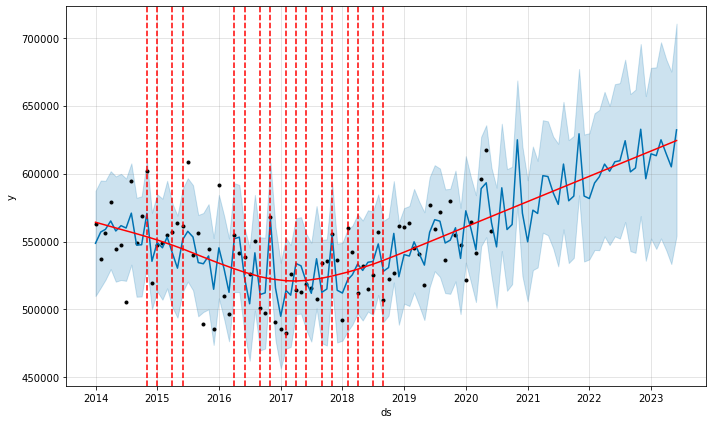

In [316]:
fig = m.plot(fcst)
chaFig = add_changepoints_to_plot(fig.gca(), m, fcst)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


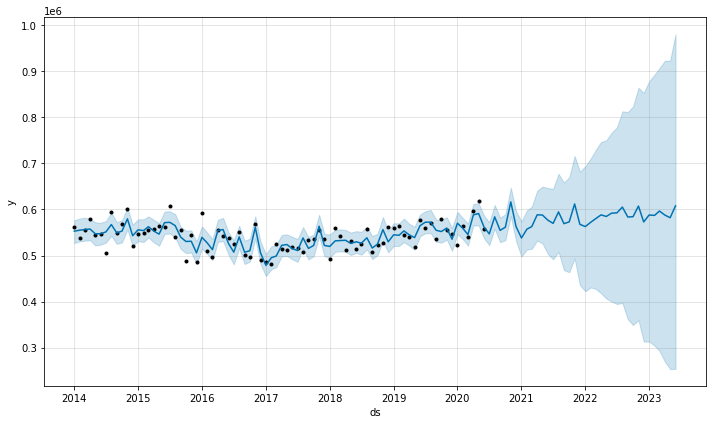

In [318]:
# Adjusting trend flexibility
m = Prophet(changepoint_prior_scale=2.6).fit(dictArea['Datong'])
future = m.make_future_dataframe(periods=36, freq='MS')
forecast = m.predict(future)
fig = m.plot(forecast)

In [319]:
pred = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
pred.to_csv("/Users/yunmo/Documents/iii/FinalReport/House/output/Prophet/pred/Datong.csv")

### Wanhua

#### Model

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


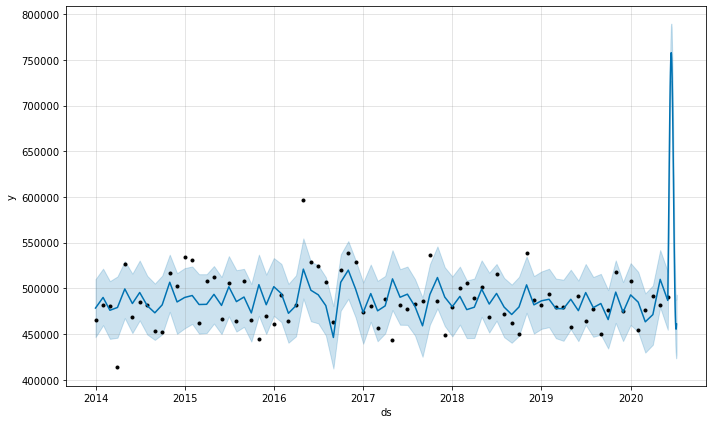

In [303]:
m = Prophet(seasonality_mode='multiplicative').fit(dictArea['Wanhua'])
future = m.make_future_dataframe(periods=36)  # 3652
fcst = m.predict(future) 
fig = m.plot(fcst)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


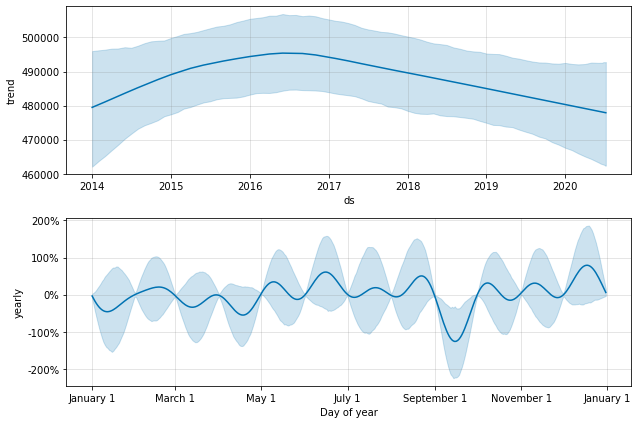

In [304]:
m = Prophet(seasonality_mode='multiplicative', mcmc_samples=300).fit(dictArea['Wanhua'])
fcst = m.predict(future)
trendFig = m.plot_components(fcst)

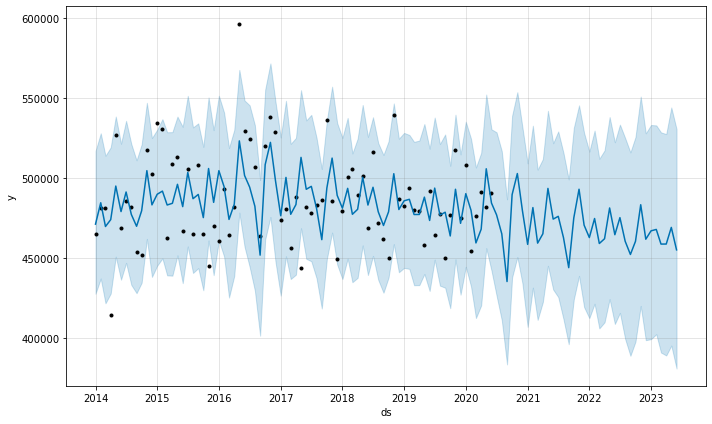

In [306]:
future = m.make_future_dataframe(periods=36, freq='MS')
fcst = m.predict(future)
fig = m.plot(fcst)

#### Trend Changepoints

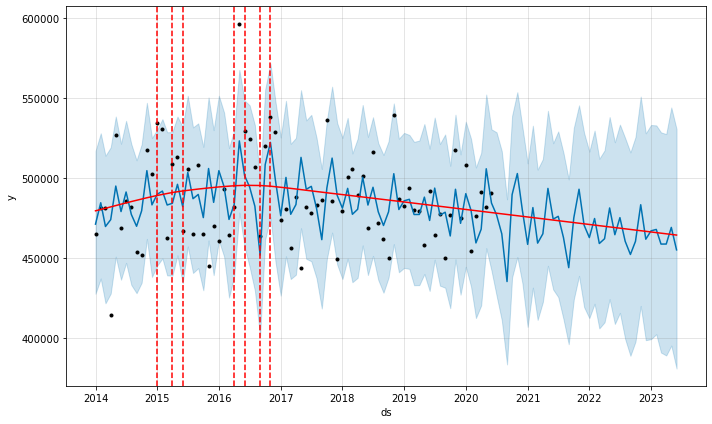

In [308]:
fig = m.plot(fcst)
chaFig = add_changepoints_to_plot(fig.gca(), m, fcst)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


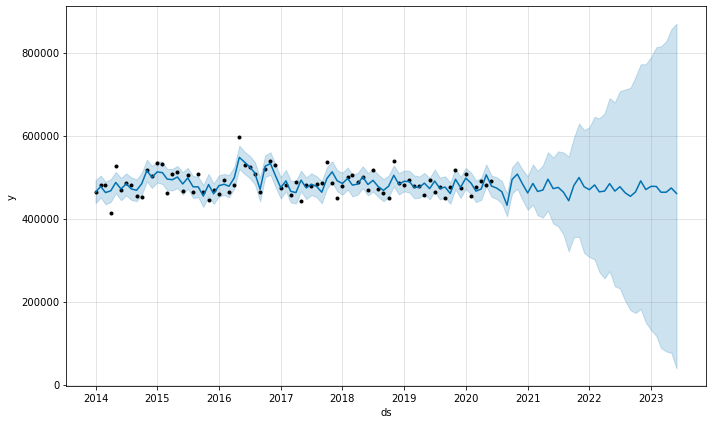

In [309]:
# Adjusting trend flexibility
m = Prophet(changepoint_prior_scale=2).fit(dictArea['Wanhua'])
future = m.make_future_dataframe(periods=36, freq='MS')
forecast = m.predict(future)
fig = m.plot(forecast)

### Wenshan

#### Model

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


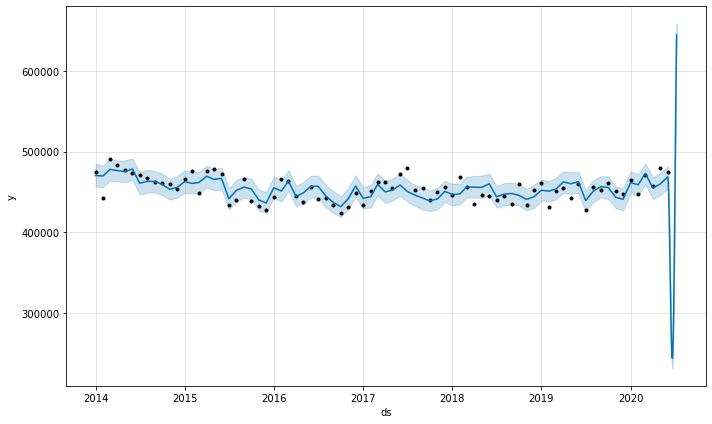

In [212]:
m = Prophet(seasonality_mode='multiplicative').fit(dictArea['Wenshan'])
future = m.make_future_dataframe(periods=36)  # 3652
fcst = m.predict(future) 
fig = m.plot(fcst)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


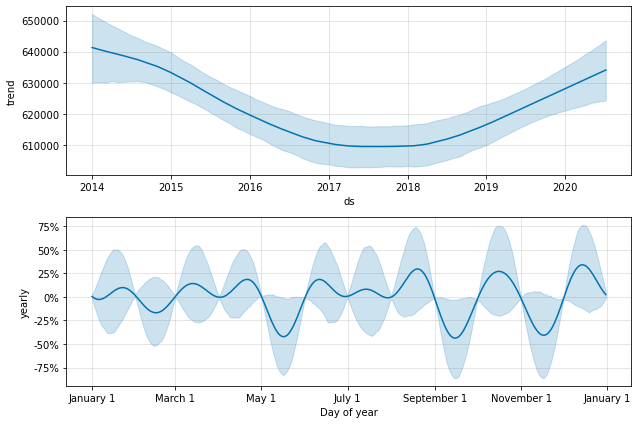

In [213]:
m = Prophet(seasonality_mode='multiplicative', mcmc_samples=300).fit(dictArea['Zhongshan'])
fcst = m.predict(future)
trendFig = m.plot_components(fcst)

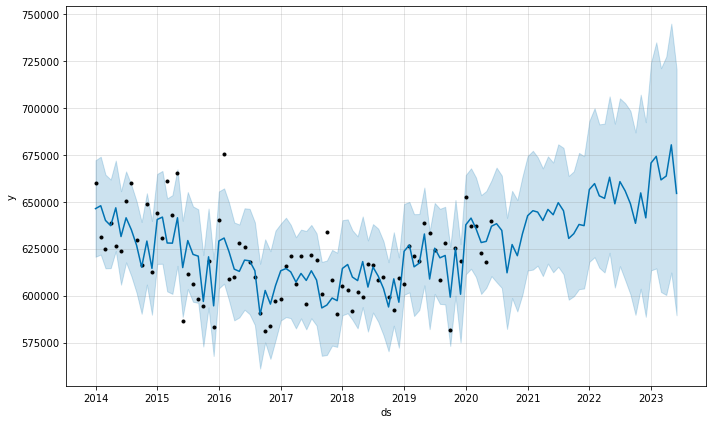

In [215]:
future = m.make_future_dataframe(periods=36, freq='MS')
fcst = m.predict(future)
fig = m.plot(fcst)

#### Trend Changepoints

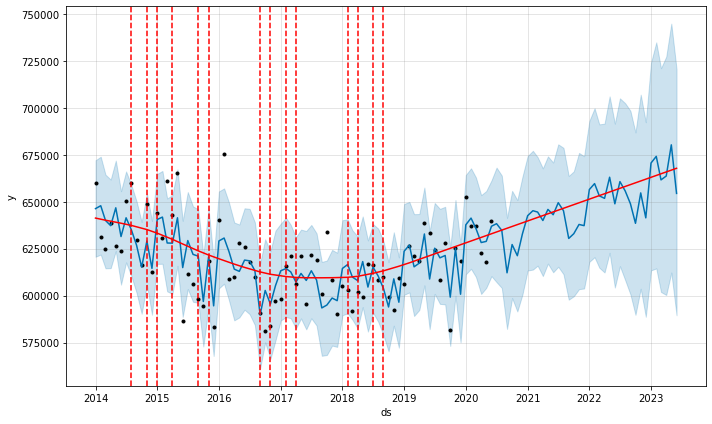

In [217]:
fig = m.plot(fcst)
chaFig = add_changepoints_to_plot(fig.gca(), m, fcst)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


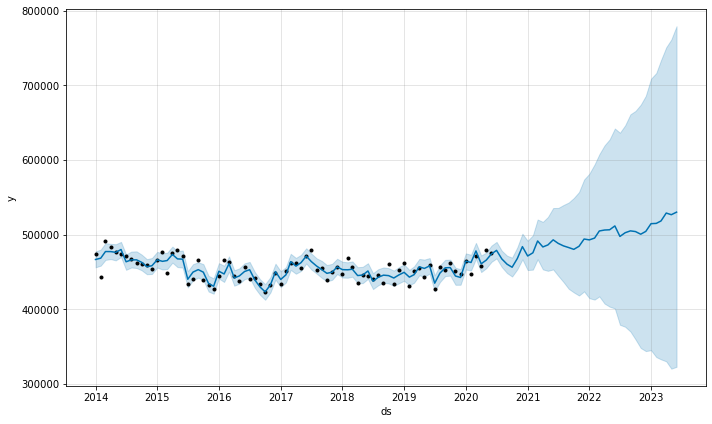

In [219]:
# Adjusting trend flexibility
m = Prophet(changepoint_prior_scale=1.2).fit(dictArea['Wenshan'])
future = m.make_future_dataframe(periods=36, freq='MS')
forecast = m.predict(future)
fig = m.plot(forecast)

### Nangang

#### Model

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


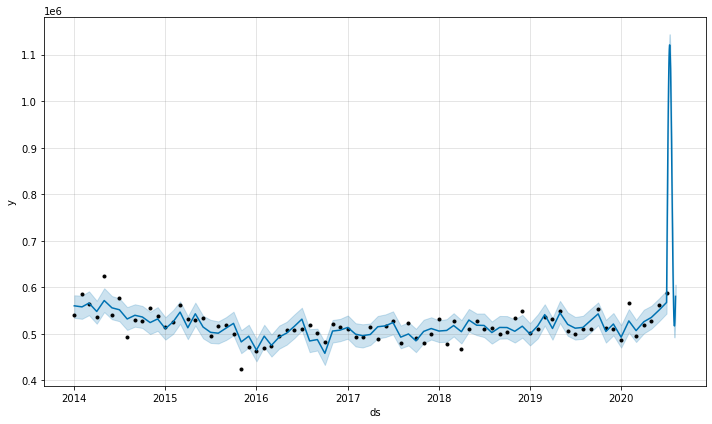

In [294]:
m = Prophet(seasonality_mode='multiplicative').fit(dictArea['Nangang'])
future = m.make_future_dataframe(periods=36)  
fcst = m.predict(future) 
fig = m.plot(fcst)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


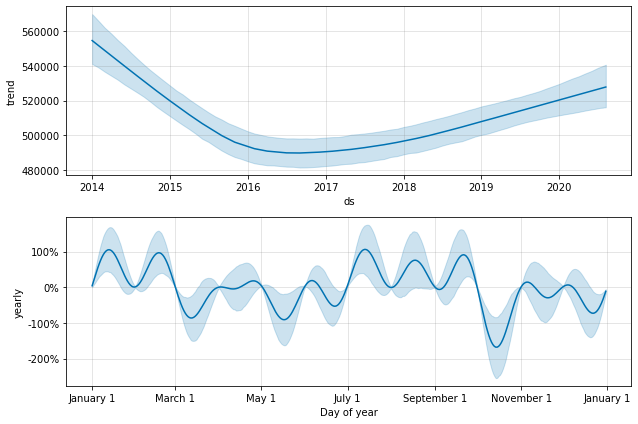

In [295]:
m = Prophet(seasonality_mode='multiplicative', mcmc_samples=300).fit(dictArea['Nangang'])
fcst = m.predict(future)
trendFig = m.plot_components(fcst)

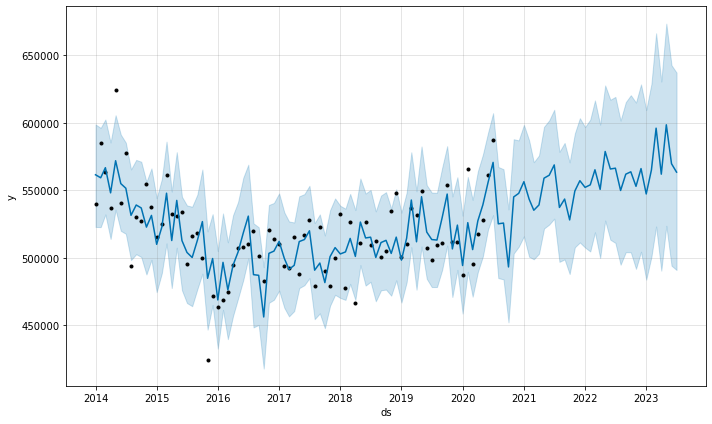

In [296]:
future = m.make_future_dataframe(periods=36, freq='MS')
fcst = m.predict(future)
fig = m.plot(fcst)

#### Trend Changepoints

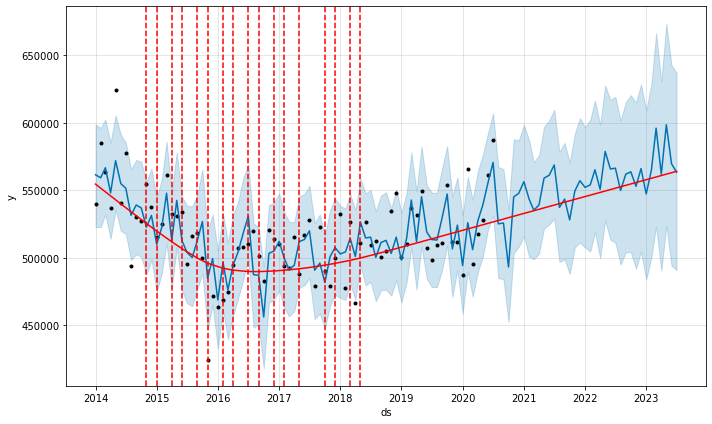

In [299]:
fig = m.plot(fcst)
chaFig = add_changepoints_to_plot(fig.gca(), m, fcst)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


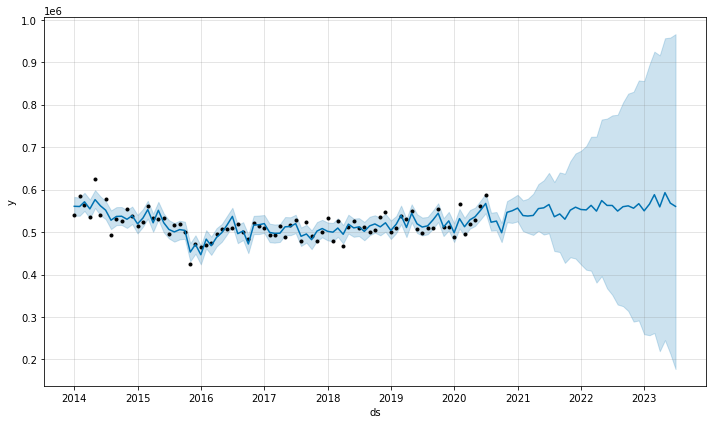

In [301]:
# Adjusting trend flexibility
m = Prophet(changepoint_prior_scale=2).fit(dictArea['Nangang'])
future = m.make_future_dataframe(periods=36, freq='MS')
forecast = m.predict(future)
fig = m.plot(forecast)

In [302]:
pred = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
pred.to_csv("/Users/yunmo/Documents/iii/FinalReport/House/output/Prophet/pred/Nangang.csv")

### Neihu

#### Model

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


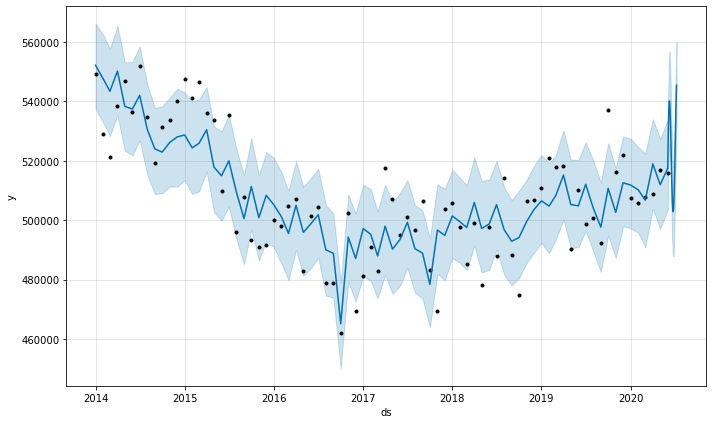

In [233]:
m = Prophet(seasonality_mode='multiplicative').fit(dictArea['Neihu'])
future = m.make_future_dataframe(periods=36)  # 3652
fcst = m.predict(future) 
fig = m.plot(fcst)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


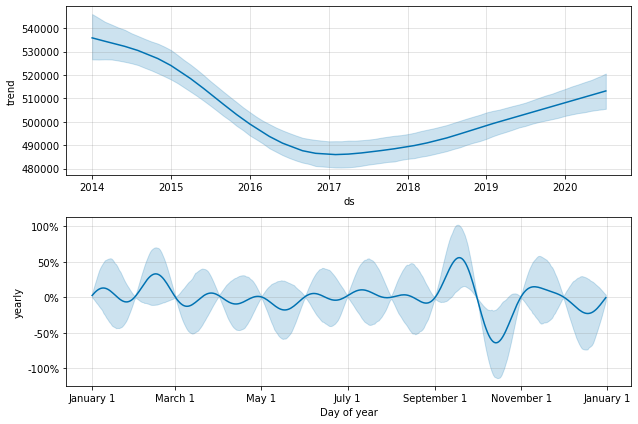

In [234]:
m = Prophet(seasonality_mode='multiplicative', mcmc_samples=300).fit(dictArea['Neihu'])
fcst = m.predict(future)
trendFig = m.plot_components(fcst)

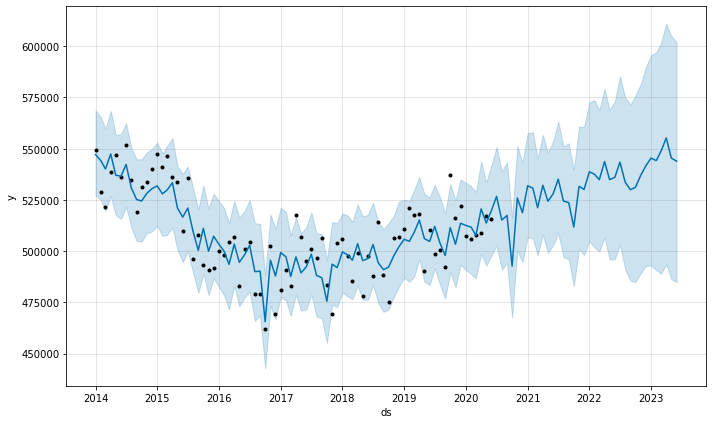

In [236]:
future = m.make_future_dataframe(periods=36, freq='MS')
fcst = m.predict(future)
fig = m.plot(fcst)

#### Trend Changepoints

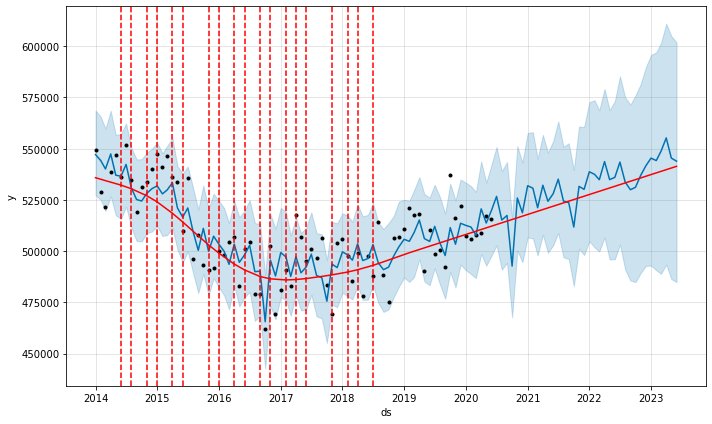

In [238]:
fig = m.plot(fcst)
chaFig = add_changepoints_to_plot(fig.gca(), m, fcst)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


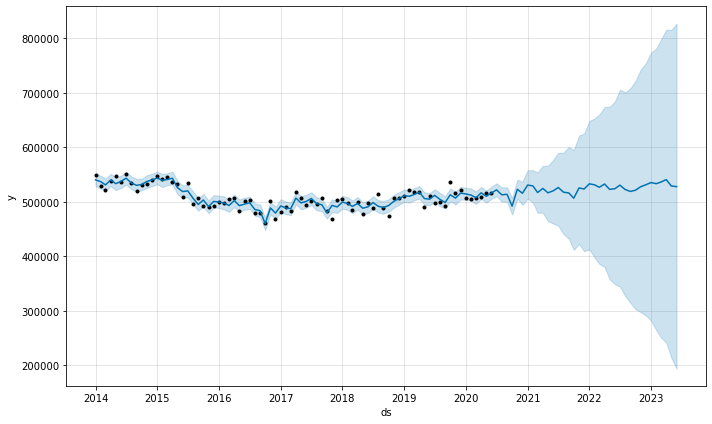

In [240]:
# Adjusting trend flexibility
m = Prophet(changepoint_prior_scale=1.2).fit(dictArea['Neihu'])
future = m.make_future_dataframe(periods=36, freq='MS')
forecast = m.predict(future)
fig = m.plot(forecast)

### Beitou

#### Model

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


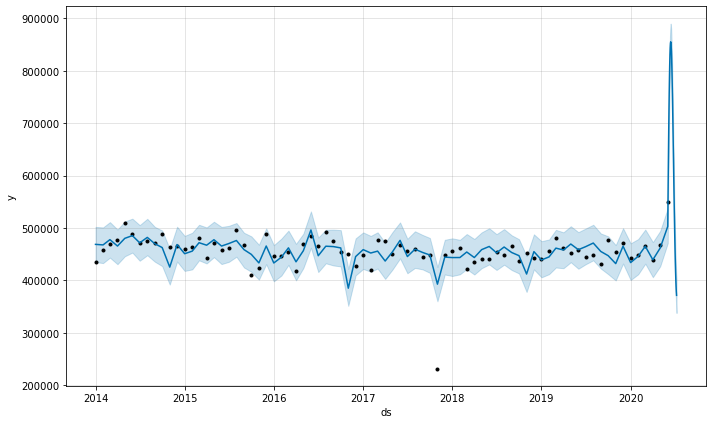

In [287]:
m = Prophet(seasonality_mode='multiplicative').fit(dictArea['Beitou'])
future = m.make_future_dataframe(periods=36)  
fcst = m.predict(future) 
fig = m.plot(fcst)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


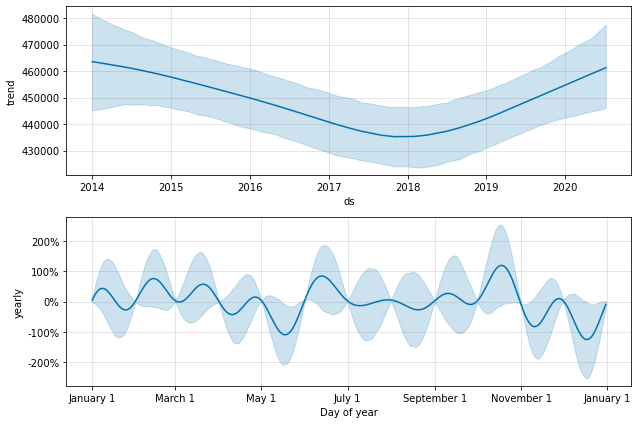

In [288]:
m = Prophet(seasonality_mode='multiplicative', mcmc_samples=300).fit(dictArea['Beitou'])
fcst = m.predict(future)
trendFig = m.plot_components(fcst)

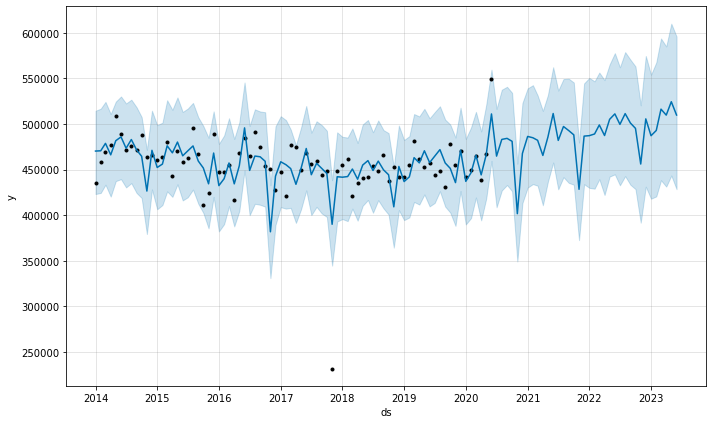

In [289]:
future = m.make_future_dataframe(periods=36, freq='MS')
fcst = m.predict(future)
fig = m.plot(fcst)

#### Trend Changepoints

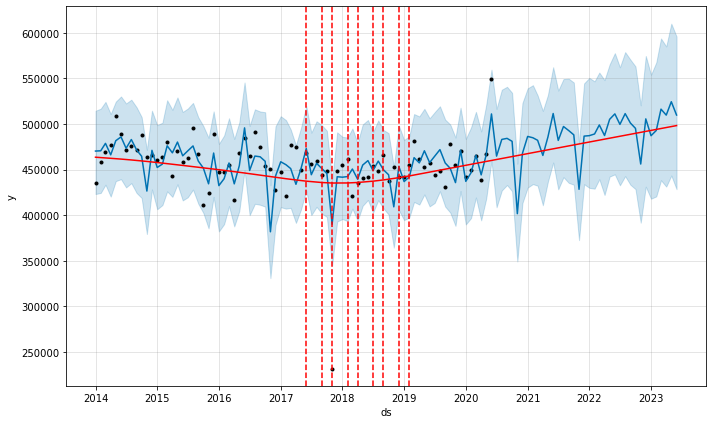

In [291]:
fig = m.plot(fcst)
chaFig = add_changepoints_to_plot(fig.gca(), m, fcst)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


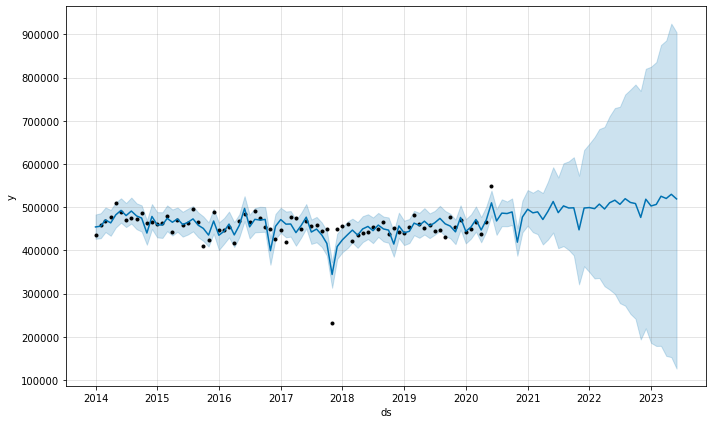

In [292]:
# Adjusting trend flexibility
m = Prophet(changepoint_prior_scale=2).fit(dictArea['Beitou'])
future = m.make_future_dataframe(periods=36, freq='MS')
forecast = m.predict(future)
fig = m.plot(forecast)

### Shilin

#### Model

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


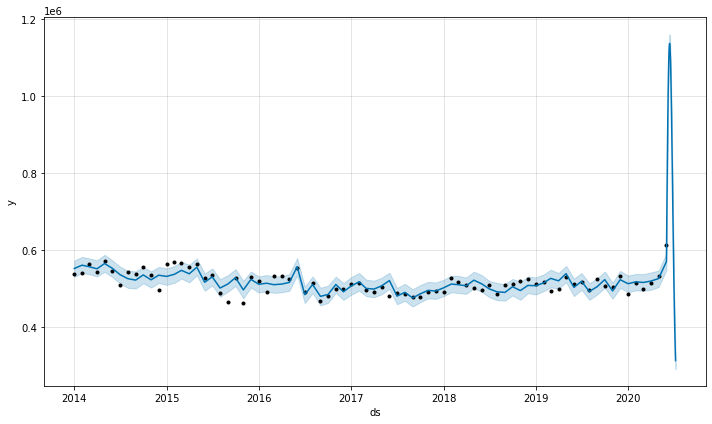

In [279]:
m = Prophet(seasonality_mode='multiplicative').fit(dictArea['Shilin'])
future = m.make_future_dataframe(periods=36)  
fcst = m.predict(future) 
fig = m.plot(fcst)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


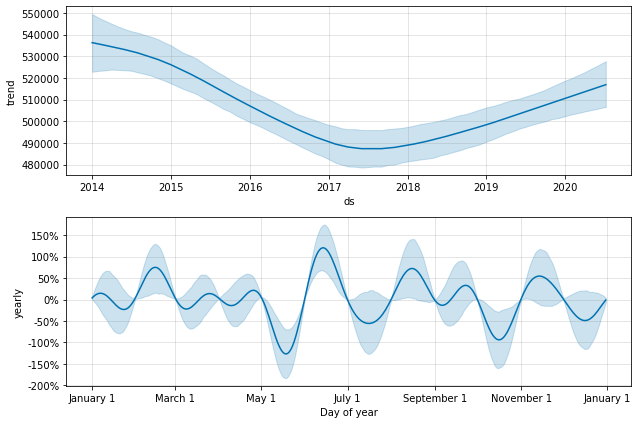

In [280]:
m = Prophet(seasonality_mode='multiplicative', mcmc_samples=300).fit(dictArea['Shilin'])
fcst = m.predict(future)
trendFig = m.plot_components(fcst)

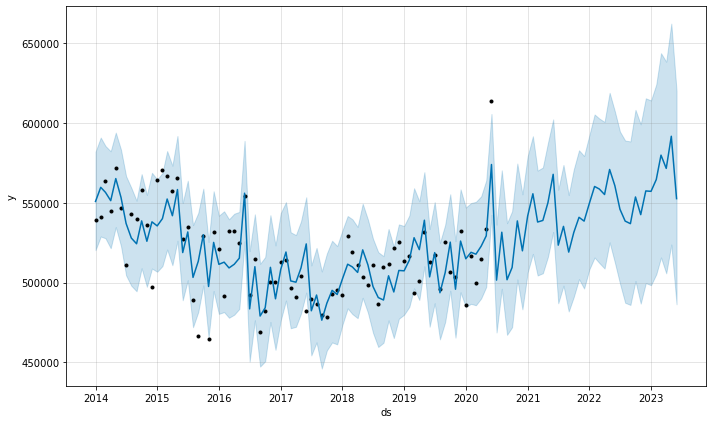

In [281]:
future = m.make_future_dataframe(periods=36, freq='MS')
fcst = m.predict(future)
fig = m.plot(fcst)

#### Trend Changepoints

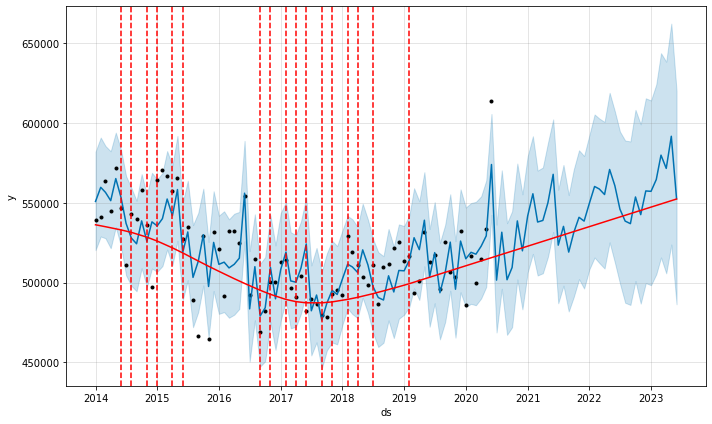

In [283]:
fig = m.plot(fcst)
chaFig = add_changepoints_to_plot(fig.gca(), m, fcst)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


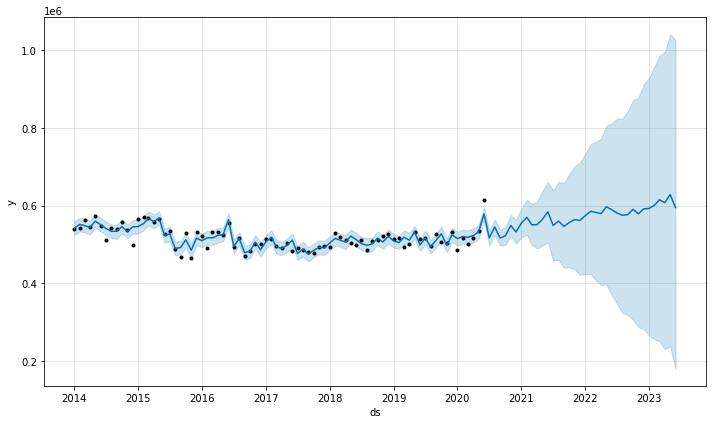

In [285]:
m = Prophet(changepoint_prior_scale=1.8).fit(dictArea['Shilin'])
future = m.make_future_dataframe(periods=36, freq='MS')
forecast = m.predict(future)
fig = m.plot(forecast)

### Taipei

#### Model

In [328]:
Taipei = mDf2.drop('Area', 1)
TaipeiDf = Taipei.groupby(['ds',], as_index=True).mean()[['y']].reset_index()
TaipeiDf.head()

ds              y
0 2014-01-01  574528.477118
1 2014-02-01  591126.459199
2 2014-03-01  568775.921873
3 2014-04-01  570955.010886
4 2014-05-01  588064.554210

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


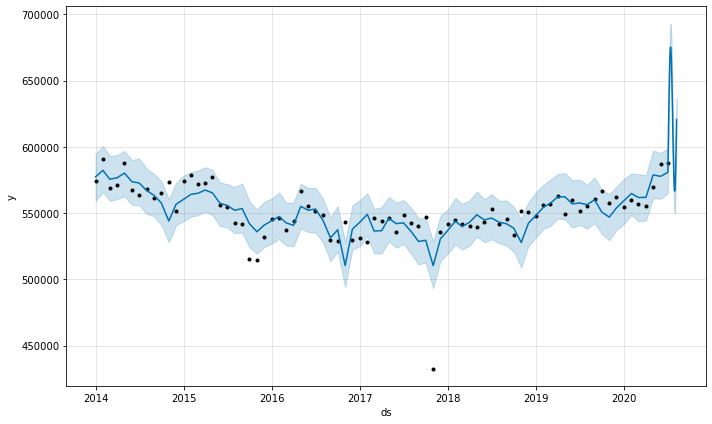

In [330]:
m = Prophet(seasonality_mode='multiplicative').fit(TaipeiDf)
future = m.make_future_dataframe(periods=36)  
fcst = m.predict(future) 
fig = m.plot(fcst)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


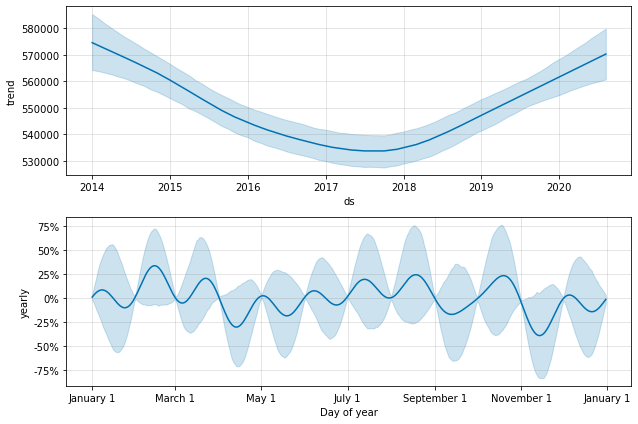

In [331]:
m = Prophet(seasonality_mode='multiplicative', mcmc_samples=300).fit(TaipeiDf)
fcst = m.predict(future)
trendFig = m.plot_components(fcst)

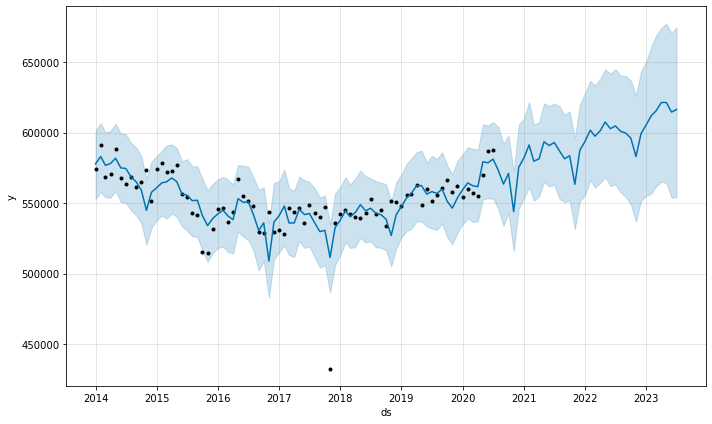

In [333]:
future = m.make_future_dataframe(periods=36, freq='MS')
fcst = m.predict(future)
fig = m.plot(fcst)

#### Trend Changepoints

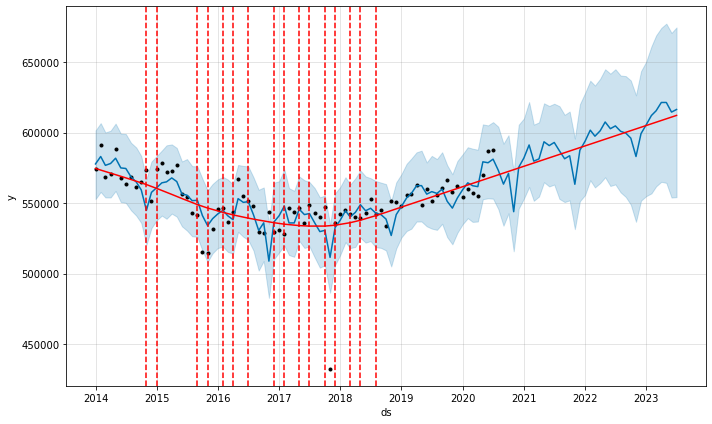

In [335]:
fig = m.plot(fcst)
chaFig = add_changepoints_to_plot(fig.gca(), m, fcst)

In [336]:
fig.savefig('/Users/yunmo/Documents/iii/FinalReport/House/output/Prophet/plot/ChangePoint/Taipei.png')

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


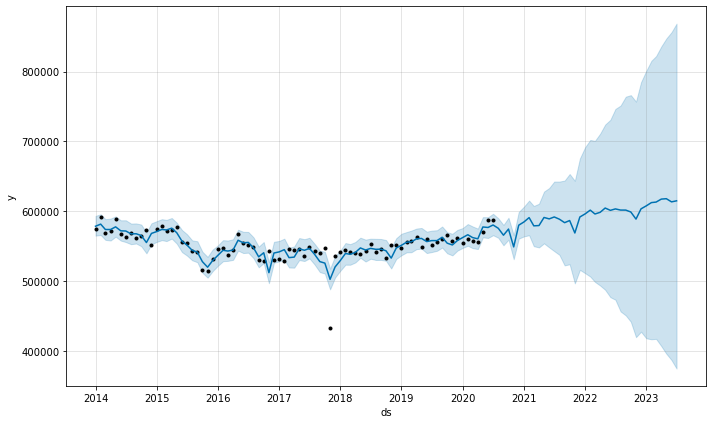

In [337]:
# Adjusting trend flexibility
m = Prophet(changepoint_prior_scale=1.8).fit(TaipeiDf)
future = m.make_future_dataframe(periods=36, freq='MS')
forecast = m.predict(future)
fig = m.plot(forecast)